# Lesson 2, State of the Art and Testing Computer Vision Models

* Key items for this week:

  * ImageDatabunch
  * cnn_learner
* Models we will look at:
  * xResNet [Bag of Tricks](https://arxiv.org/abs/1812.01187)
  * Densenet [Densenet Paper](https://arxiv.org/abs/1608.06993?source=post_page---------------------------)
  * EfficiencyNet [EfficiencyNet Paper](https://arxiv.org/abs/1905.11946)


In [0]:
from fastai.vision import *
from fastai.vision.models.xresnet import *

# Dataset:

Our dataset today will be ImageWoof. [Link](https://github.com/fastai/imagenette)

Goal: Using no pre-trained weights, see how well of accuracy we can get in x epochs



In [0]:
def get_data(size, woof, bs, workers=None):
    if   size<=128: path = URLs.IMAGEWOOF_160 if woof else URLs.IMAGENETTE_160
    elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = untar_data(path)

    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)

    return (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))

In [0]:
data = get_data(256, True, 64)

# Key Ideas:

* Label Smoothing Cross Entropy - State of the art in classification loss functions (We will explore this more in week 6) [paper](https://arxiv.org/abs/1906.11567)

  * Basically threshold instead of 1/0

* MixUp [docs](https://docs.fast.ai/callbacks.mixup.html)
  * Mixup involves "mixing" sets of images together instead of feeding raw images
  


# Label Smoothing Cross Entropy

I won't go into specifics of how it all works, as that will be for week 6 . However here is the code:

In [0]:
from torch.distributions.beta import Beta

def lin_comb(a, b, frac_a): return (frac_a * a) + (1 - frac_a) * b

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

# Mixup:

  A very basic example:
  
  `new_image = t * image1 + (1-t) * image2`
  
  Where `t` is a float between 0 and 1. The target we assign is the same combination as the original,
  `new_target = t * target1 + (1-t) * target2`

In [0]:
img1, lbl1 = data.train_ds[0]; lbl1

Category n02115641

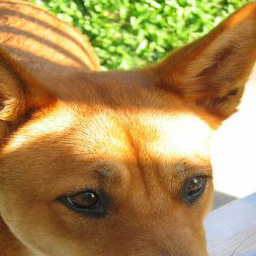

In [0]:
img1

In [0]:
img2, lbl2 = data.train_ds[1]; lbl2

Category n02115641

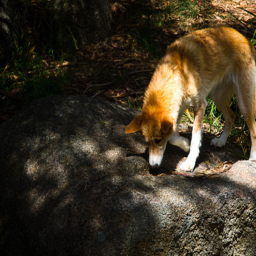

In [0]:
img2

In [0]:
t = 0.4

In [0]:
new_image = t * img1.data + (1-t) * img2.data
new_target = t * lbl1.data + (1-t) * lbl2.data

In [0]:
im = image2np(new_image)

In [0]:
import matplotlib.pyplot as plt

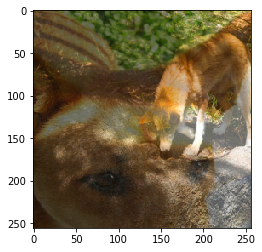

In [0]:
plt.imshow(im)

In [0]:
new_target

9.0

# MixUp + LSCE Base

In [0]:
learn = cnn_learner(data, models.resnet34, pretrained=False, metrics=[accuracy, top_k_accuracy], loss_func=LabelSmoothingCrossEntropy()).mixup().to_fp16()

Mixed Precision:

* 16 bit and 32 bit processors at once
* to undo learn.to_fp32()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


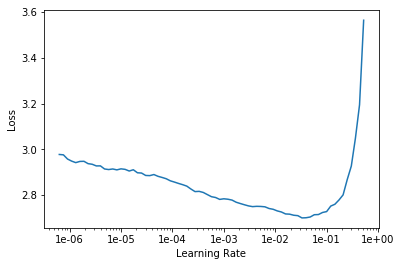

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
bs_rat = data.batch_size/256

In [0]:
lr = 3e-3
lr *= bs_rat

In [0]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.523005,2.436179,0.180000,0.638000,01:32
1,2.331267,2.188036,0.170000,0.720000,01:30
2,2.178244,1.973323,0.362000,0.816000,01:30
3,2.096927,1.832069,0.394000,0.884000,01:30
4,1.987325,1.691961,0.480000,0.922000,01:30


In [0]:
def pretty_results(learn:Learner):
  _, acc, err = learn.validate()
  print(f'Results: \nAccuracy: {round(float(acc),4)}\nTop k Accuracy: {round(float(err),4)}')

In [0]:
pretty_results(learn)

Results: 
Accuracy: 0.48
Top k Accuracy: 0.922


# xResNet + RAdam + LSCE

In [8]:
!git clone https://github.com/LiyuanLucasLiu/RAdam.git

Cloning into 'RAdam'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 94 (delta 25), reused 83 (delta 20), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [6]:
%cd RAdam
from radam import *

/content/RAdam


In [0]:
opt = partial(RAdam)

In [0]:
learn = Learner(data, models.xresnet50(), metrics=accuracy, wd=1e-3,
               opt_func=opt, bn_wd=False, true_wd=True,
               loss_func=LabelSmoothingCrossEntropy())

In [0]:
lr = 3e-2

In [10]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.105839,3.660304,0.202000,03:05
1,2.719219,2.864689,0.288000,03:02
2,2.519284,2.526159,0.386000,03:03
3,2.325073,2.434830,0.418000,03:02
4,2.143890,2.117049,0.568000,03:03


In [0]:
learn.metrics.append(top_k_accuracy)

In [20]:
pretty_results(learn)

Results: 
Accuracy: 0.568
Top k Accuracy: 0.946


# DenseNet

In [0]:
from fastai.vision.models import densenet121

In [0]:
learn = Learner(data, densenet121(), metrics=[accuracy, top_k_accuracy], 
                loss_func = LabelSmoothingCrossEntropy()).mixup().to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


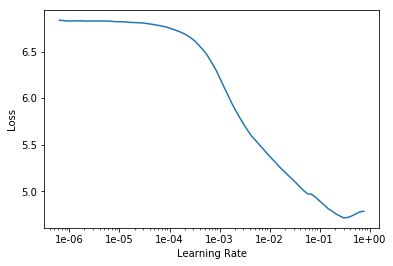

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-03
lr *= bs_rat

In [0]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.421218,2.817743,0.250000,0.788000,01:56
1,2.769037,2.679536,0.352000,0.836000,01:56
2,2.627109,2.441563,0.446000,0.888000,01:55
3,2.470749,2.199248,0.538000,0.934000,01:55
4,2.404066,2.136268,0.596000,0.940000,01:55


In [0]:
pretty_results(learn)

Results: 
Accuracy: 0.596
Top k Accuracy: 0.94


# efficientnet

In [21]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=0d2b2f4de74c6e3c481f2e17d48dd29c1651c39f41671295c26f22ca73598680
  Stored in directory: /root/.cache/pip/wheels/27/56/13/5bdaa98ca8bd7d5da65cc741987dd14391b87fa1a09081d17a
Successfully built efficientnet-pytorch


In [0]:
from efficientnet_pytorch import EfficientNet

In [0]:
net = EfficientNet.from_name('efficientnet-b3')

In [0]:
model_name = 'efficientnet-b2'
def getModel(pret):
    model = EfficientNet.from_name(model_name)
#     model._bn1 = nn.Identity()
    model._fc = nn.Linear(1408,data.c)
    return model

In [0]:
learn = Learner(data, getModel(False), metrics=[accuracy, top_k_accuracy], 
                 opt_func=opt, loss_func = LabelSmoothingCrossEntropy()).mixup().to_fp16()

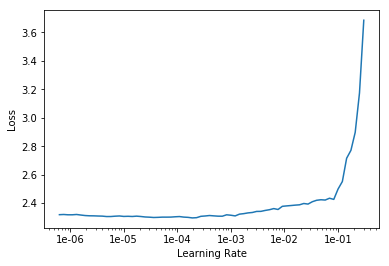

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 3e-3
lr *= bs_rat

In [30]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.278014,2.302983,0.100000,0.500000,02:10
1,2.196462,2.308947,0.100000,0.500000,02:09
2,2.121310,2.217754,0.208000,0.666000,02:09
3,2.035502,1.961837,0.322000,0.844000,02:09
4,1.994712,1.797163,0.430000,0.880000,02:09


# Cutout and Blend Augmentation

Cut out does exactly as you would think, we "Cut Out" some of the image, which has been seen to help! Based on [this](https://arxiv.org/pdf/1708.04552.pdf) paper

Blend: By Ignacio Oguiza "This is a powerful abstraction for image data augmentation that generalizes MixUp, Cutout, CutMix, RICAP, and more, and allows annealing of the amount of augmentation during training (to support curriculum learning)" - Jeremy Howard on Twitter

In [0]:
!git clone https://github.com/oguiza/fastai_extensions.git

Cloning into 'fastai_extensions'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 99 (delta 34), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [0]:
%cd 'fastai_extensions/shared/0_image_data_augmentation'

/content/fastai_extensions/shared/0_image_data_augmentation


In [0]:
from exp.nb_new_data_augmentation import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


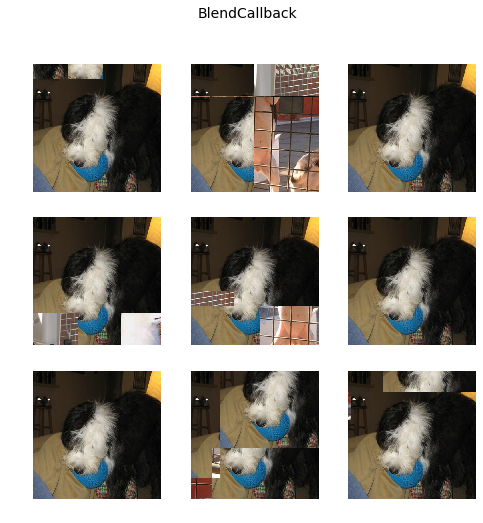

In [0]:
from exp.nb_new_data_augmentation import *
kwargs = {
    'size': .3,            # range(0.-1.) You can indicate the size of the patched area/s
    'alpha': 1.,           # This is used to define a proba distribution
    'fixed_proba': 0,      # This overrides alpha proba distribution. Will fix the % of the image that is modified
    'grid': True,          # Determine if patches may overlap or not. With True they do not overlap
    'blend_type': 'cut',   # Options: 'zero', 'noise', 'mix', 'cut', 'random'
    'same_size': False,     # All patches may have the same size or not
    'same_crop': False,    # Cropping patches are from the same subregion as input patches (only with 'mix' and 'cut')
    'same_image': False,   # Cropping patches will be from the same or different images (only with 'mix' and 'cut')
}
learn = Learner(data,models.resnet34(pretrained=False), metrics=[accuracy, top_k_accuracy], 
                loss_func=LabelSmoothingCrossEntropy()).blend(**kwargs).to_fp16().show_tfms()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.959457,5.236727,0.096000,0.522000,04:37
1,0.739676,3.209184,0.102000,0.486000,04:32
2,0.944402,3.866750,0.142000,0.622000,04:31
3,0.978325,3.171866,0.160000,0.686000,04:30
4,1.033067,3.074821,0.172000,0.696000,04:32


# ClassConfusion

Lastly is ClassConfusion. This is meant to help explain how your model is behaving and understand where it's weaknesses are. We will examine it through images today, and we will look at it for tabular next week.

[docs](https://docs.fast.ai/widgets.class_confusion.html)

For use with regular jupyter notebooks, use `from fastai.widgets import ClassConfusion`

For use with Google Colab, use my repo: [repo](https://github.com/muellerzr/ClassConfusion)

In [0]:
!git clone https://github.com/muellerzr/ClassConfusion

Cloning into 'ClassConfusion'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 334 (delta 28), reused 0 (delta 0), pack-reused 284
Receiving objects: 100% (334/334), 2.13 MiB | 13.21 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [0]:
from ClassConfusion import *

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused()[:5]

[('n02089973', 'n02088364', 20),
 ('n02096294', 'n02087394', 14),
 ('n02099601', 'n02087394', 14),
 ('n02096294', 'n02093754', 10),
 ('n02105641', 'n02086240', 10)]

In [0]:
comboList = [('n02089973', 'n02088364')]

Please enter a value for `k`, or the top images you will see: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

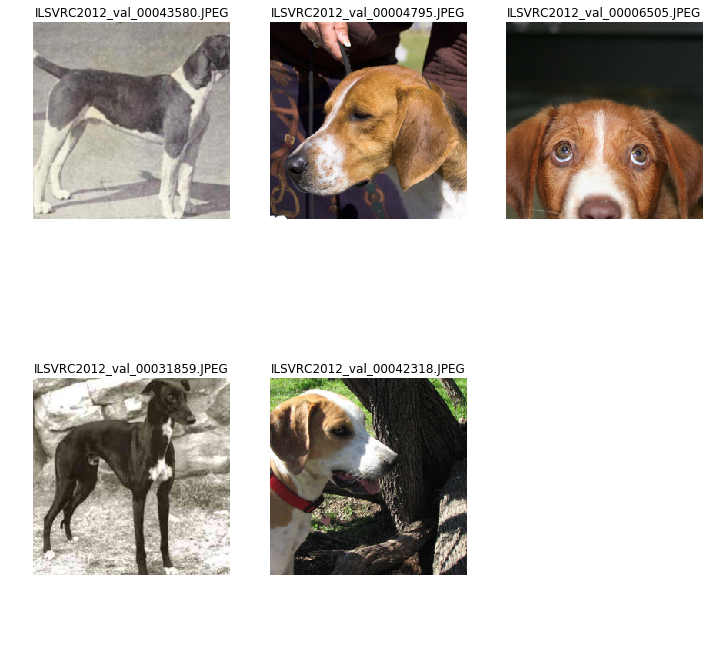

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


In [0]:
ClassConfusion(interp, comboList, is_ordered=True, figsize=(12,12))

In [0]:
comboList = ['n02089973', 'n02088364', ]

Please enter a value for `k`, or the top images you will see: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

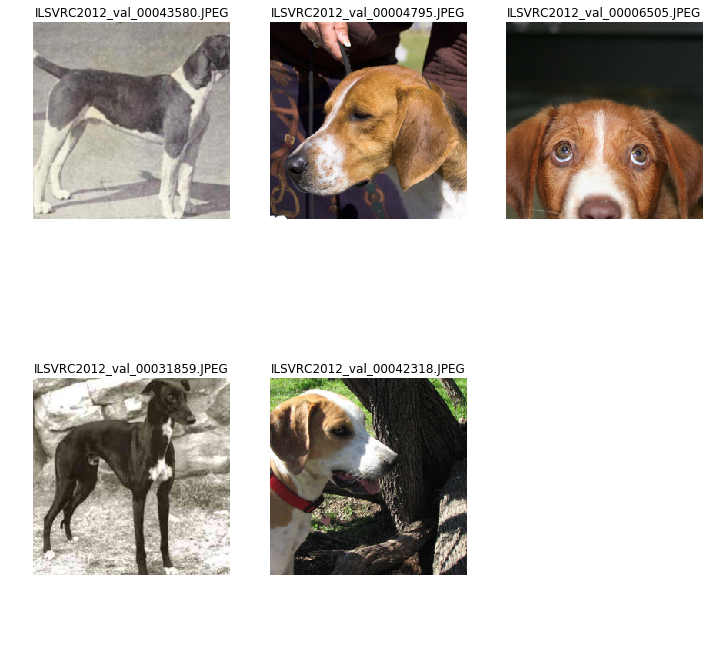

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

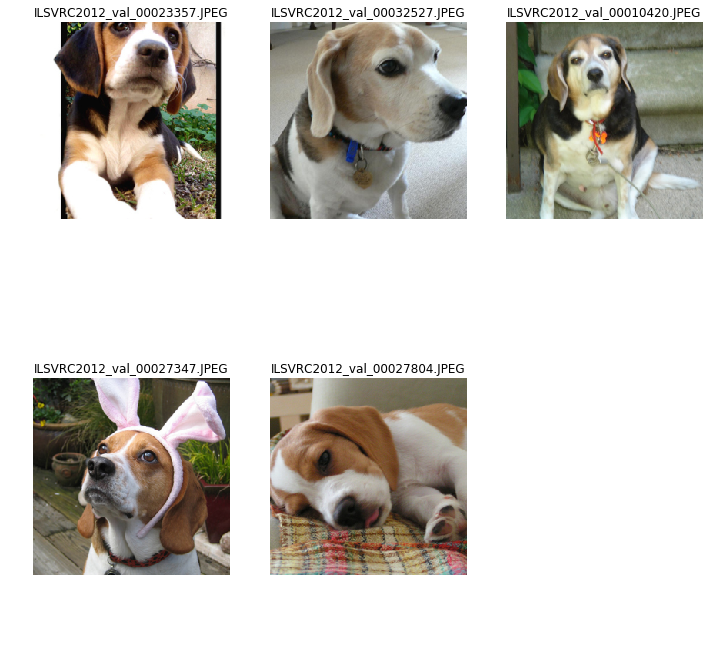

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

 50%|█████     | 1/2 [00:05<00:05,  5.09s/it]


In [0]:
ClassConfusion(interp, comboList, is_ordered=False, figsize=(12,12))